In [2]:
library(tidyverse)
library(tidymodels)
library(themis)
library(repr)
library(broom)
library(rvest)
library(infer)
library(cowplot)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 10 rows

# Project Final Report

## Introduction

#### General Information
This Final Report will be conducted on datasets provided by a research group in Computer Science at UBC, led by Frank Wood, in which the research group collected data about how players play video games. The datasets provided include `players.csv`, which provides the general information about each participant, and `sessions.csv`, which provides individual session information from each player.  

#### Aim

The aim of this final report is to gain relevent information regarding two questions. Firstly a broad question
* Which player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

and secondly, a more specific question
* How accurately can just age and just hours played predict subscription to a game-related newsletter compared to a prediction using both age and hours played in `players.csv`?

By doing so, we can help the computer science research group and their stakeholders understand their data using our specific question to gain insight into the broader question.  

#### Datasets

As stated in our specific question, we will be working on the dataset `players.csv`. 

#### Data Characteristics  
The `players.csv` represents 196 individuals who particiapated in the study, described by 7 features, including:
* `experience <chr>` - Player's experience
* `subscribe <lgl>` - Whether the player subscribed to a video game newsletter
* `hashedEmail <chr>` - Unique identifier for each player
* `played_hours <dbl>` - Total hours played
* `name <chr>` - First Name
* `gender <chr>` - Gender
* `age <dbl>` - Age in years

##### Data Summary
* `experience` is composed of
    * `Beginner`
    * `Amateur`
    * `Regular`
    * `Veteran`
    * `Pro`
* `subscribe` is composed of 144 `TRUE` and 52 `FALSE`  
* `gender` is composed of
    * `Male`
    * `Female`
    * `Non-binary`
    * `Two-Spirited`
    * `Agender`
    * `Other`
    * `Prefer not to say`
* `played_hours`
    * Maximum - 223.1 hours
    * Minimum - 0 hours
    * Average - 5.845918 Hours
* `Age`
    * Oldest - 50 years
    * Youngest - 8 years
    * Mean - 20.52 years


##### Potential Issues
* Column `Age` contains `NA`
* Dataset is male dominated
* Dataset is majority Amateur players.
* Order of experience not specified, we will be assuming `Beginner -> Amateur -> Regular -> Pro -> Veteran`

## Methods and Results

Our specific question is primarily a predictive data analysis question. We are looking to determine if just `age` or just `played_hours` can predict whether a player will subscribe to a video game newsletter more accurately then both `age` and `played_hours` can. Because `subscribe` has two categories `TRUE` if the player subscribed to a video game newsletter or `FALSE` if the player didn't, we can seperately analyze the accuracy of using `age` as to predict `subscription`, using `played_hours` to predict `subscription` and using both `age` and `played_hours` to predict `subscription`.  

In order to determine which classification method we should use, we need to first wrangle and tidy the data, then look at data visualizations regarding `age` and `played_hours`.

In [3]:
# Reading and viewing the players.csv data
url <- "https://raw.githubusercontent.com/ckwok07/DSCI-100-Project-Final-Report/refs/heads/main/data/players.csv"
players <- read_csv(url)
# Checking for NA values in Age
players_age_na <- players |>
    filter(is.na(Age))
players_age_na

# Checking for NA values in played_hours
players_played_na <- players |>
    filter(is.na(played_hours))
players_played_na

# Checking for NA values in experience
players_experience_na <- players |>
    filter(is.na(experience))
players_experience_na

# Checking for NA values in subscribe
players_subscribe_na <- players |>
    filter(is.na(subscribe))
players_subscribe_na

# Thus only the Age column has NA values. In addition to that, because the amount of NA values in Age is relatively small, 
# we can remove them from the dataset instead of imputing the individuals' age as dropping these two players will not impact
# the dataset very much.

# Removing the NA values of age from the dataframe
players <- players |>
    filter(!is.na(Age))

#In addition to that, we must turn the subscribe column into a factor data type as it has 2 categories that we are going to predict
players <- players |>
    mutate(subscribe = as.factor(subscribe))
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Regular,TRUE,7d71c49cbbce8dcf0276b2bfecfa2d16f22cb31a4024556d6085884298f2ee8d,0.1,Devin,Two-Spirited,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


Once our data is wrangled and tidy, we can visualize the relationships between `age` and `subscribe` as well as the relationship between `played_hours` and `subscribe`

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


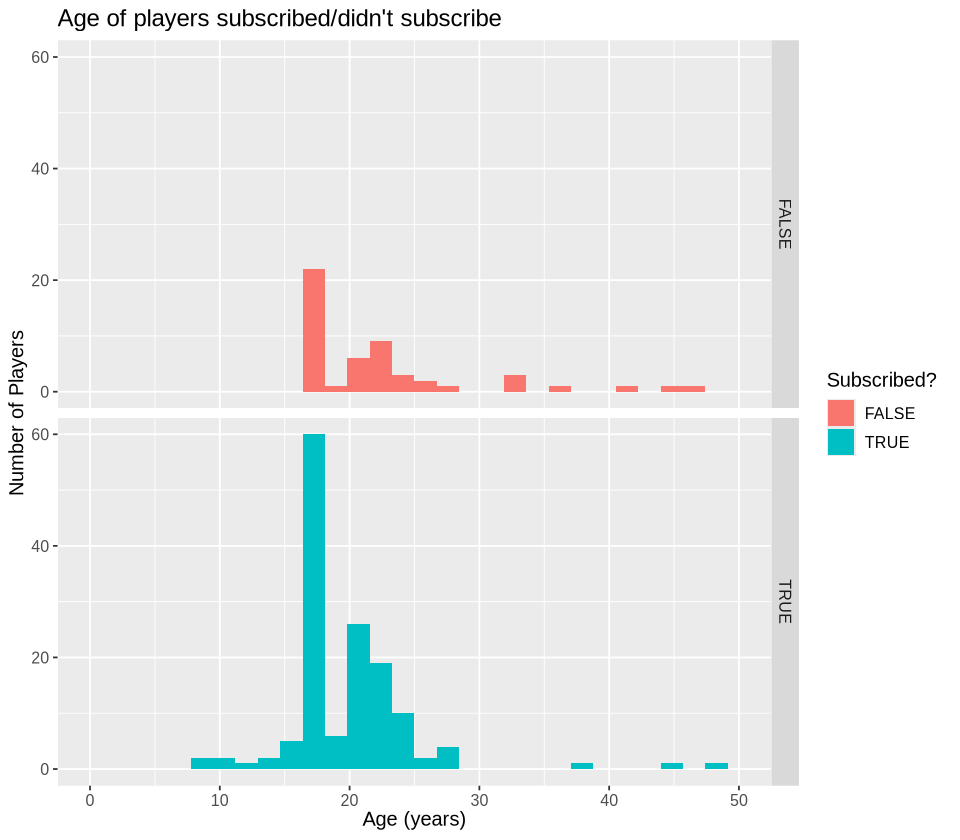

In [99]:
options(repr.plot.width = 8, repr.plot.height = 7)

# Histogram visualization of the relationship between age and subscribe
players_age_subscribe_plot <- players |>
    ggplot(aes(x = Age, fill = subscribe)) +
    geom_histogram() +
    facet_grid(rows = vars(subscribe)) +
    labs(title = "Age of players subscribed/didn't subscribe", x = "Age (years)" , y = "Number of Players", fill = "Subscribed?") +
    xlim(c(0, 50)) +
    ylim(c(0,60)) +
    theme(text = element_text(size = 12))
players_age_subscribe_plot

_**(Figure 1)**: Figure 1 is split into 2 histograms. These 2 histograms display the age distribution of players who subscribed to a video game newsletter and those who did not. The x-axis indicates the players age in years and the y-axis indicates the number of players in each age. The top panel represents players in each age group who did not subscribe, while the bottomm panel represents players in each group who did subscribe._

From **Figure 1**, we can analyze the relationship between `Age` and `subscribe` in the `players.csv` dataset. In the `subscribe = TRUE` portion of the visualization, at first glance, it seems that as `age` increases, number of players subscribing to a video game newsletter decreases. However, this is not the case, because if it were, then the number of players not subscribed as age increases would be increasing, which is not reflected in the `subscribe = FALSE` portion of **Figure 1**.  Thus, there doesn't seem to be a distinct relationship shape between age and number of people subscribing to a video game newsletter.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


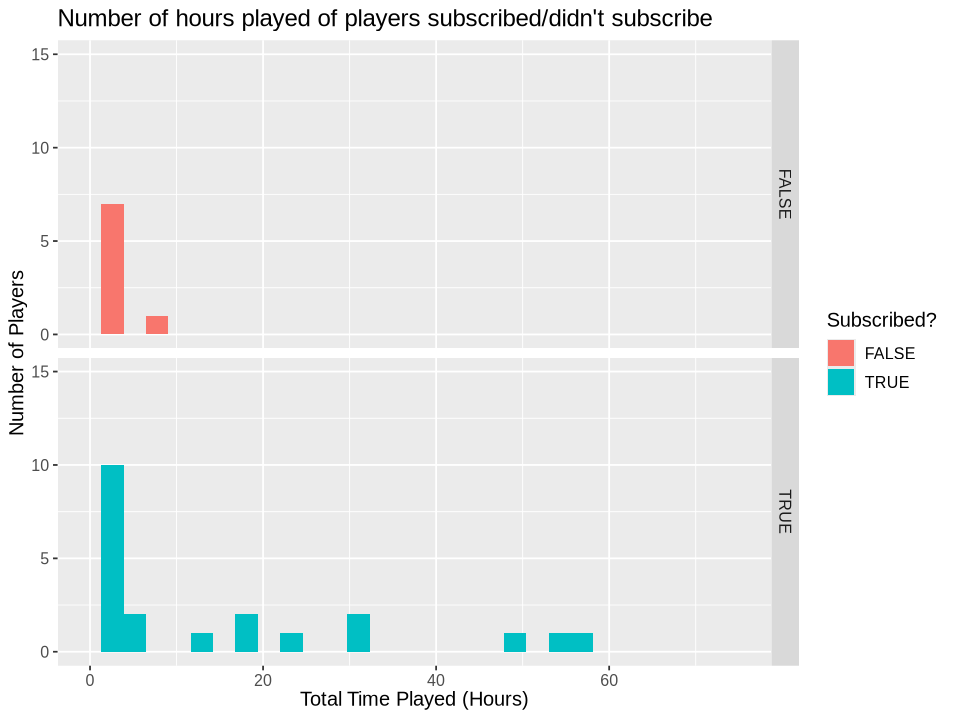

In [102]:
options(repr.plot.width = 8, repr.plot.height = 6)

# Histogram visualization of the relationship between played_hours and subscribe
players_played_hours_subscribe_plot <- players |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram() +
    facet_grid(rows = vars(subscribe)) +
    labs(title = "Number of hours played of players subscribed/didn't subscribe", x = "Total Time Played (Hours)" , y = "Number of Players", fill = "Subscribed?") +
    xlim(c(0, 75)) +
    ylim(c(0,15)) +
    theme(text = element_text(size = 12))
players_played_hours_subscribe_plot

_**(Figure 2)**: Figure 2 is split into 2 histograms. These 2 histograms display the distribution of player's total time played who subscribed to a video game newsletter and those who did not. The x-axis indicates the total time played in hours and the y-axis indicates the number of players in each grouping of hours. The top panel represents players in each hours played group who did not subscribe, while the bottom panel represents players in each hours played group who did subscribe._

**Figure 2** illustrates that as `played_hours` increases, there are more people subscribing to a video game newsletter. Besides that there are no distinguishible patterns within the visualization

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


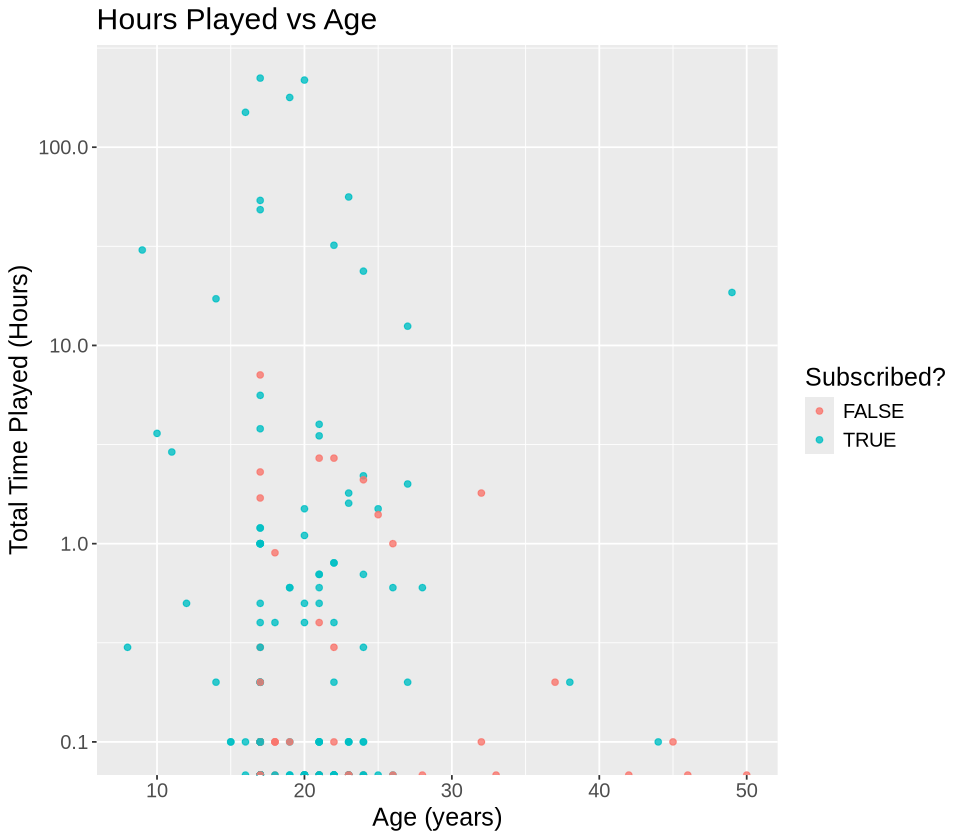

In [105]:
# Scatterplot visualization of the relationship between age, played_hours and subscribe
players_age_played_hours_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.8) + 
    labs(title = "Hours Played vs Age", x = "Age (years)", y = "Total Time Played (Hours)", color = "Subscribed?") +
    scale_y_log10() +
    theme(text = element_text(size = 15))
players_age_played_hours_plot

_**(Figure 3)**: Figure 3 is a scatterplot that visualizes the relationship between `age` and `played_hours` colored by whether or not the player subscribed to a vidoe game newsletter. Each point represents a player. The x-axis indicates the player's age in years while the y-axis indicates the player's total time played in hours. Blue points indicate players who did subscribe and orange points indicate players who did not subscribe._

Besides a higher `played_hours` eluding to a higher likelyhood of subscription to a video game newsletter, **Figure 3** illustraites there is no positive or negative linear relationship between `Age`, `played_hours`, and `subscribe`.  

Because each predictor variable(s) have hard, undistiguishible relationships with `subscribe` we will preform KNN classificaiton to predict whether or not a player will subscribe to a video game newsletter using just `Age` as a predictor, `played_hours` as a predictor, and both `Age` and `played_hours` as predictors. This is because the KNN algorithm makes no assumptions about data distribution/relationship shape.  

In order to use KNN classification we will first split the dataset into 70% Training and 30% Testing sets. In addition to that, scaling, tuning and cross-validation will be performed to determine the most accurate k-value for our algorithms.

In [103]:
set.seed(1234) # Seed for possible recreation

# Splitting the players dataframe into training and testing sets
players_split <- initial_split(players, prop = 0.7, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

# Checking the proportions of FALSE and TRUE subscriptions in original dataframe
player_proportions <- players |>
    group_by(subscribe) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(players))
player_proportions

# Checking the proportions of FALSE and TRUE subscriptions in training dataframe
player_training_proportions <- players_training |>
    group_by(subscribe) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(players_training))
player_training_proportions

# Checking the proportions of FALSE and TRUE subscriptions in testing dataframe
player_testing_proportions <- players_testing |>
    group_by(subscribe) |>
    summarize(n=n()) |>
    mutate(percent = 100*n/nrow(players_testing))
player_testing_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,36,26.66667
TRUE,99,73.33333


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,16,27.11864
TRUE,43,72.88136


**(Figure 4)**:

The ratio of `TRUE` and `FALSE` in the column `subscribe` are roughly the same for the original, training, and testing datasets. Thus we can begin training our classifiers.

In [106]:
set.seed(1234) # Seed for possible recreation

# Creating our KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Specifying the number of folds in our cross-validation + which variable we are predicting
players_vfold <- vfold_cv(players_training, v = 10, strata = subscribe)

# K-value tibble for cross validation
k_vals <- tibble(neighbors = seq(from = 1, to = 100))

In [115]:
set.seed(1234) # Seed for possible recreation

# Recipe using Age to predict subscription using the training data + scaling predictors
players_age_recipe <- recipe(subscribe ~ Age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Results of the cross valudation.
knn_age_results <- workflow() |>
    add_recipe(players_age_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

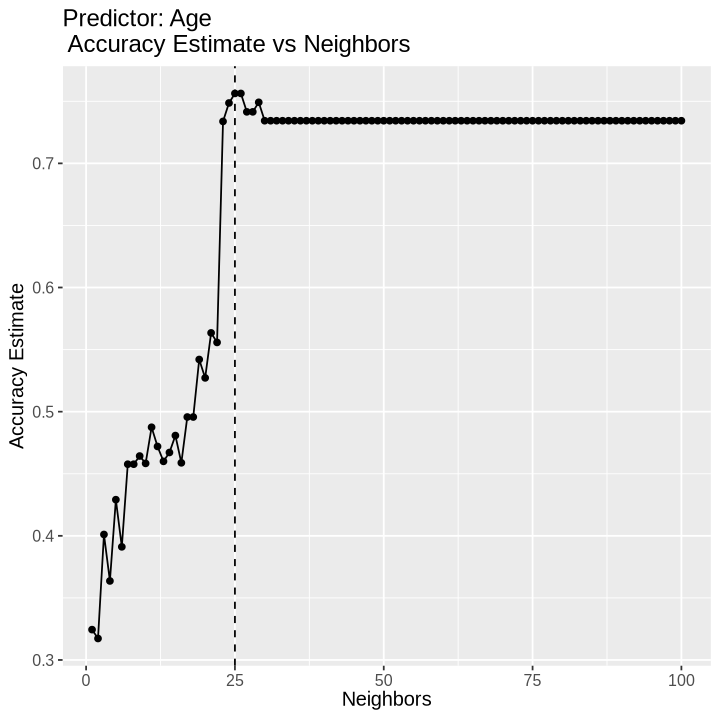

In [110]:
set.seed(1234) # Seed for possible recreation
options(repr.plot.width = 6, repr.plot.height = 6)

# Filtering metrics for just accuracy
age_accuracies <- knn_age_results |>
    filter(.metric == "accuracy")

# Pulling the most accurate k-value
best_k_age <- age_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

# Accuracy Estimate vs Neighbors visualization.
accuracy_vs_k_age <- ggplot(age_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = best_k_age, linetype = "dashed") +
  labs(title = "Predictor: Age \n Accuracy Estimate vs Neighbors", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
accuracy_vs_k_age

_**(Figure 5)**: Figure 5 is a line plot that visualizes how the classification accuracy of predicting `subscribe` changes as the number of neighbors (k-value) increases, using age as the sole predictor. The x-axis indicates the number of neighbors (from 1 to 100) in the KNN model, while the y-axis indicates the cross-validated accuracy estimate for each number of neighbors. The vertical dashed line indicates the number of neighbors that yields the highest accuracy_

In [119]:
set.seed(1234) # Seed for possible recreation

# Model for KNN classification using neighbor value that yields highest accuracy (K = 25)
best_knn_spec_age <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_age) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fitting the recipe and model to the testing data
knn_fit_age <- workflow() |>
  add_recipe(players_age_recipe) |>
  add_model(best_knn_spec_age) |>
  fit(data = players_testing)

# Predicting + binding predictions onto the testing data
players_age_test_prediction <- predict(knn_fit_age, players_testing) |>
    bind_cols(players_testing)

# Filtering for accuracy
players_age_test_prediction_acc <- players_age_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
players_age_test_prediction_acc

# Confusion Matrix for this algorithm's performance on the testing data
players_age_test_prediction_conf <- players_age_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
players_age_test_prediction_conf

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     16   43

**(Figure 6)**:

In [116]:
set.seed(1234) # Seed for possible recreation

# Recipe using played_hours to predict subscription using the training data + scaling predictors 
players_played_hours_recipe <- recipe(subscribe ~ played_hours, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Results of the cross valudation
knn_played_hours_results <- workflow() |>
    add_recipe(players_played_hours_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

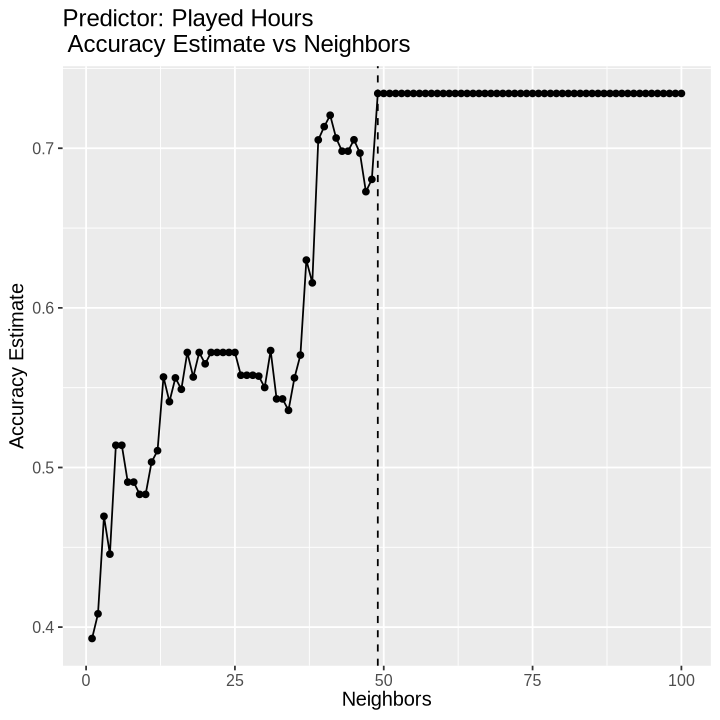

In [120]:
set.seed(1234) # Seed for possible recreation

# Filtering metrics for just accuracy
played_hours_accuracies <- knn_played_hours_results |>
    filter(.metric == "accuracy")

# Pulling the most accurate k-value
best_k_played_hours <- played_hours_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

# Accuracy Estimate vs Neighbors visualization
accuracy_vs_k_played_hours <- ggplot(played_hours_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = best_k_played_hours, linetype = "dashed") +
  labs(title = "Predictor: Played Hours \n Accuracy Estimate vs Neighbors", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
accuracy_vs_k_played_hours

_**(Figure 7)**: Figure 7 is a line plot that visualizes how the classification accuracy of predicting `subscribe` changes as the number of neighbors (k-value) increases, using played hours as the sole predictor. The x-axis indicates the number of neighbors (from 1 to 100) in the KNN model, while the y-axis indicates the cross-validated accuracy estimate for each number of neighbors. The vertical dashed line indicates the number of neighbors that yields the highest accuracy_

In [121]:
set.seed(1234) # Seed for possible recreation

# Model for KNN classification using neighbor value that yields highest accuracy (K = 49)
best_knn_spec_played_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_played_hours) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fitting the recipe and model to the testing data
knn_fit_played_hours <- workflow() |>
  add_recipe(players_played_hours_recipe) |>
  add_model(best_knn_spec_played_hours) |>
  fit(data = players_testing)

# Predicting + binding predictions onto the testing data
players_played_hours_test_prediction <- predict(knn_fit_played_hours, players_testing) |>
    bind_cols(players_testing)

# Filtering for accuracy
players_played_hours_test_prediction_acc <- players_played_hours_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
players_played_hours_test_prediction_acc

# Confusion Matrix for this algorithm's performance on the testing data
players_played_hours_test_prediction_conf <- players_played_hours_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
players_played_hours_test_prediction_conf

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     16   43

**(Figure 8)**:

In [30]:
set.seed(1234) # Seed for possible recreation

# Recipe using age and played_hours to predict subscription using the training data + scaling predictors 
players_age_played_hours_recipe <- recipe(subscribe ~ Age + played_hours, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Results of the cross-validation
knn_age_played_hours_results <- workflow() |>
    add_recipe(players_age_played_hours_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

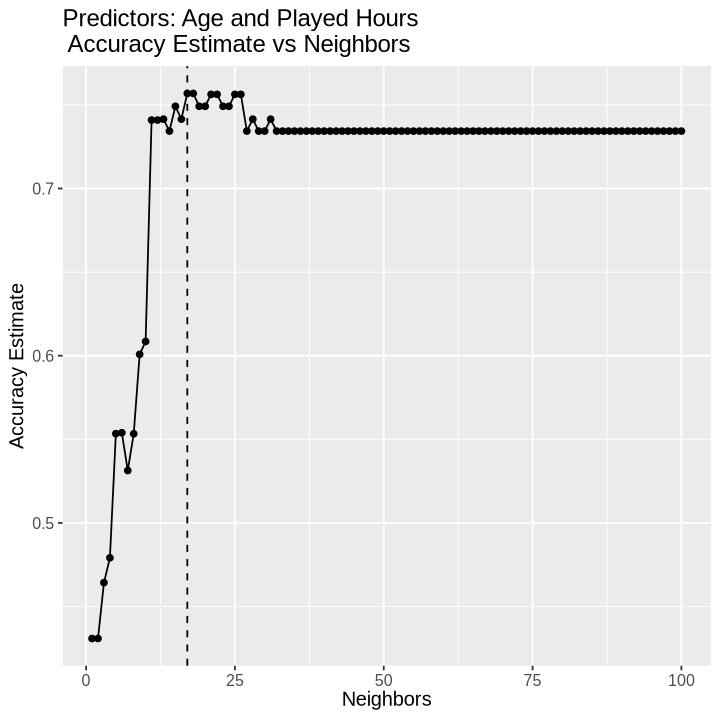

In [123]:
set.seed(1234) # Seed for possible recreation

# Filtering metrics for just accuracy
age_played_hours_accuracies <- knn_age_played_hours_results |>
    filter(.metric == "accuracy")

# Pulling the most accurate k-value
best_k_age_played_hours <- age_played_hours_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

# Accuracy Estimate vs Neighbors visualization.
accuracy_vs_k_age_played_hours <- ggplot(age_played_hours_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = best_k_age_played_hours, linetype = "dashed") +
  labs(title = "Predictors: Age and Played Hours \n Accuracy Estimate vs Neighbors", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
accuracy_vs_k_age_played_hours

_**(Figure 9)**: Figure 9 is a line plot that visualizes how the classification accuracy of predicting `subscribe` changes as the number of neighbors (k-value) increases, using age and played hours as predictors. The x-axis indicates the number of neighbors (from 1 to 100) in the KNN model, while the y-axis indicates the cross-validated accuracy estimate for each number of neighbors. The vertical dashed line indicates the number of neighbors that yields the highest accuracy_

In [124]:
set.seed(1234) # Seed for possible recreation

# Model for KNN classification using neighbor value that yields highest accuracy (K = 17)
best_knn_spec_age_played_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_age_played_hours) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fitting the recipe and model to the testing data
knn_fit_age_played_hours <- workflow() |>
  add_recipe(players_age_played_hours_recipe) |>
  add_model(best_knn_spec_age_played_hours) |>
  fit(data = players_testing)

# Predicting + binding predictions onto the testing data
players_age_played_hours_test_prediction <- predict(knn_fit_age_played_hours, players_testing) |>
    bind_cols(players_testing)

# Filtering for accuracy
players_age_played_hours_test_prediction_acc <- players_age_played_hours_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
players_age_played_hours_test_prediction_acc

# Confusion Matrix for this algorithm's performance on the testing data
players_age_played_hours_test_prediction_conf <- players_age_played_hours_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
players_age_played_hours_test_prediction_conf

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     16   43

_**(Figure 10)**:_

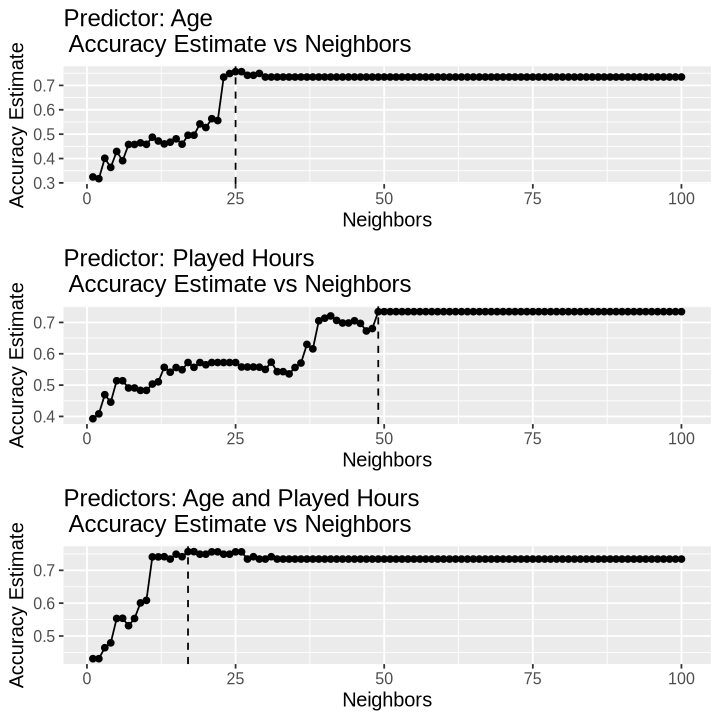

In [130]:
# Stacking Figure 5, Figure 7, and Figure 9
plot_grid(accuracy_vs_k_age, accuracy_vs_k_played_hours, accuracy_vs_k_age_played_hours, ncol = 1)

_**(Figure 11)** :_

In [131]:
# Pulling the accuracy for the age predicting model
age_accuracy <- players_age_test_prediction_acc |>
    pull(.estimate)

# Pulling the accuracy for the played_hours predicting model
played_hours_accuracy <- players_played_hours_test_prediction_acc |>
    pull(.estimate)

# Pulling the accuracy for the age + played_hours predicting model
age_played_hours_accuracy <- players_age_played_hours_test_prediction_acc |>
    pull(.estimate)

# Creating tibble for each model's k-value and accuracy
accuracies <- tibble(predictors = c("Age", "played_hours", "Age_played_hours"),
                     k_value = c(best_k_age, best_k_played_hours, best_k_age_played_hours),
                     accuracies = c(age_accuracy, played_hours_accuracy, age_played_hours_accuracy))
accuracies

predictors,k_value,accuracies
<chr>,<int>,<dbl>
Age,25,0.7288136
played_hours,49,0.7288136
Age_played_hours,17,0.7288136


_**(Figure 12)** :_

## Weird that accuracies are all the same, might be due to class imbalance in `subscribe`

In [126]:
set.seed(1234) # Seed for possible recreation

# Recipe for upsampling players dataframe
players_recipe_balance <- recipe(subscribe ~ ., data = players) |>
  step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
  prep()

# Upsampling players dataframe
upsampled_players <- bake(players_recipe_balance, players)

In [12]:
set.seed(1234) # Seed for possible recreation

#Spitting the upsampled dataframe into training and testing sets 
unsampled_players_split <- initial_split(upsampled_players, prop = 0.7, strata = subscribe)
upsampled_players_training <- training(unsampled_players_split)
upsampled_players_testing <- testing(unsampled_players_split)

# Specifying the number of folds in our cross-validation + which variable we are predicting
upsampled_players_vfold <- vfold_cv(upsampled_players_training, v = 10, strata = subscribe)

In [129]:
# Checking Ratio of TRUE and FALSE in suscribe column in players
upsampled_players |>
  group_by(subscribe) |>
  summarize(n = n()) |>
  mutate(percent = 100*n/nrow(upsampled_players))

# Checking Ratio of TRUE and FALSE in suscribe column in training set
upsampled_players_training |>
  group_by(subscribe) |>
  summarize(n = n()) |>
  mutate(percent = 100*n/nrow(upsampled_players_training))

# Checking Ratio of TRUE and FALSE in suscribe column in testing set
upsampled_players_testing |>
  group_by(subscribe) |>
  summarize(n = n()) |>
  mutate(percent = 100*n/nrow(upsampled_players_testing))

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,142,50
TRUE,142,50


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,99,50
TRUE,99,50


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,43,50
TRUE,43,50


_**(Figure 13)** :_

In [47]:
set.seed(1234) # Seed for possible recreation

# Recipe using Age to predict subscription using the upsampled training data + scaling predictors
upsampled_players_age_recipe <- recipe(subscribe ~ Age, data = upsampled_players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Results of the cross valudation.
upsampled_knn_age_results <- workflow() |>
    add_recipe(upsampled_players_age_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = upsampled_players_vfold, grid = k_vals) |>
    collect_metrics()

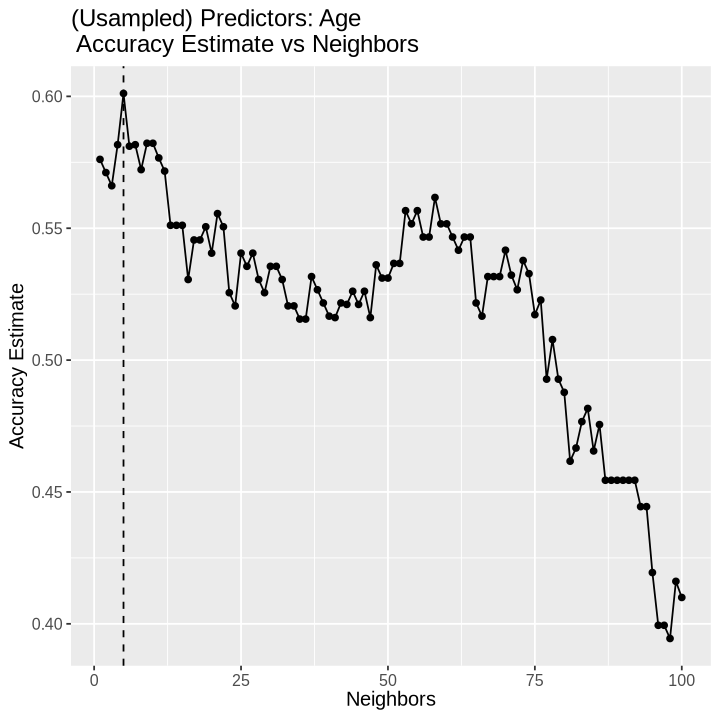

In [76]:
set.seed(1234) # Seed for possible recreation

# Filtering metrics for just accuracy
upsampled_age_accuracies <- upsampled_knn_age_results |>
    filter(.metric == "accuracy")

# Pulling the most accurate k-value
upsampled_best_k_age <- upsampled_age_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)

# Accuracy Estimate vs Neighbors visualization.
upsampled_accuracy_vs_k_age <- ggplot(upsampled_age_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = upsampled_best_k_age, linetype = "dashed") +
  labs(title = "(Usampled) Predictors: Age \n Accuracy Estimate vs Neighbors", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
upsampled_accuracy_vs_k_age

_**(Figure 14)** :_

In [68]:
set.seed(1234) # Seed for possible recreation

# Model for KNN classification using neighbor value that yields highest accuracy (K = 5)
upsampled_best_knn_spec_age <- nearest_neighbor(weight_func = "rectangular", neighbors = upsampled_best_k_age) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fitting the recipe and model to the upsampled testing data
upsampled_knn_fit_age <- workflow() |>
  add_recipe(upsampled_players_age_recipe) |>
  add_model(upsampled_best_knn_spec_age) |>
  fit(data = upsampled_players_testing)

# Predicting + binding predictions onto the upsampled testing data
upsampled_players_age_test_prediction <- predict(upsampled_knn_fit_age, upsampled_players_testing) |>
    bind_cols(upsampled_players_testing)

# Filtering for accuracy
upsampled_players_age_test_prediction_acc <- upsampled_players_age_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
upsampled_players_age_test_prediction_acc

# Confusion Matrix for this algorithm's performance on the upsampled testing data
upsampled_players_age_test_prediction_conf <- upsampled_players_age_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
upsampled_players_age_test_prediction_conf

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5697674


          Truth
Prediction FALSE TRUE
     FALSE    39   33
     TRUE      4   10

_**(Figure 15)** :_

In [51]:
set.seed(1234) # Seed for possible recreation

# Recipe using played_hours to predict subscription using the upsampled training data + scaling predictors
upsampled_players_played_hours_recipe <- recipe(subscribe ~ played_hours, data = upsampled_players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Results of the cross valudation.
upsampled_knn_played_hours_results <- workflow() |>
    add_recipe(upsampled_players_played_hours_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = upsampled_players_vfold, grid = k_vals) |>
    collect_metrics()

[1] 2

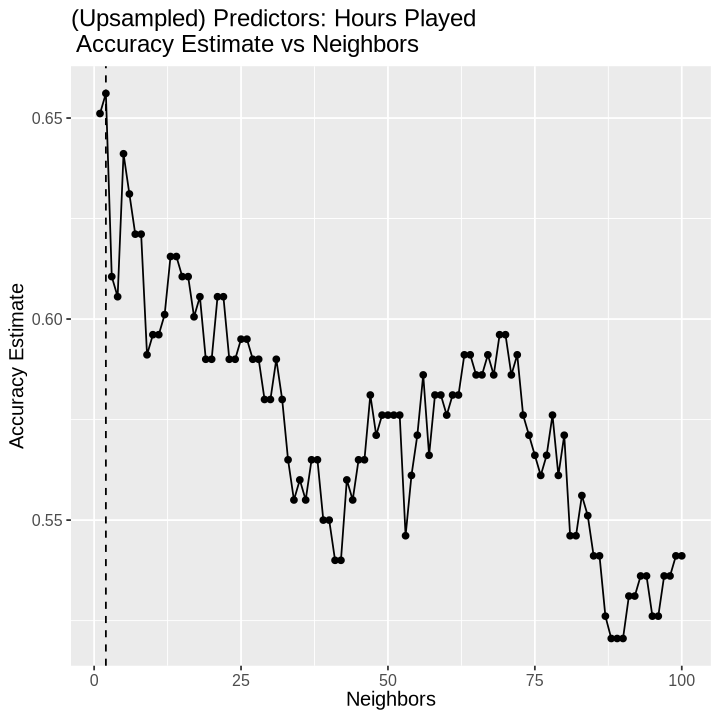

In [75]:
set.seed(1234) # Seed for possible recreation

# Filtering metrics for just accuracy
upsampled_played_hours_accuracies <- upsampled_knn_played_hours_results |>
    filter(.metric == "accuracy")

# Pulling the most accurate k-value
upsampled_best_k_played_hours <- upsampled_played_hours_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
upsampled_best_k_played_hours

# Accuracy Estimate vs Neighbors visualization
upsampled_accuracy_vs_k_played_hours <- ggplot(upsampled_played_hours_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = upsampled_best_k_played_hours, linetype = "dashed") +
  labs(title = "(Upsampled) Predictors: Hours Played \n Accuracy Estimate vs Neighbors", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
upsampled_accuracy_vs_k_played_hours

_**(Figure 16)** :_

In [66]:
set.seed(1234) # Seed for possible recreation

# Model for KNN classification using neighbor value that yields highest accuracy (K = 2)
upsampled_best_knn_spec_played_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = upsampled_best_k_played_hours) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fitting the recipe and model to the upsampled testing data
upsampled_knn_fit_played_hours <- workflow() |>
  add_recipe(upsampled_players_played_hours_recipe) |>
  add_model(upsampled_best_knn_spec_played_hours) |>
  fit(data = upsampled_players_testing)

# Predicting + binding predictions onto the upsampled testing data
upsampled_players_played_hours_test_prediction <- predict(upsampled_knn_fit_played_hours, upsampled_players_testing) |>
    bind_cols(upsampled_players_testing)

# Filtering for accuracy
upsampled_players_played_hours_test_prediction_acc <- upsampled_players_played_hours_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
upsampled_players_played_hours_test_prediction_acc

# Confusion Matrix for this algorithm's performance on the upsampled testing data
upsampled_players_played_hours_test_prediction_conf <- upsampled_players_played_hours_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
upsampled_players_played_hours_test_prediction_conf

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.627907


          Truth
Prediction FALSE TRUE
     FALSE    43   32
     TRUE      0   11

_**(Figure 17)** :_

In [62]:
set.seed(1234) # Seed for possible recreation

# Recipe using Age and played_hours to predict subscription using the upsampled training data + scaling predictors
upsampled_players_age_played_hours_recipe <- recipe(subscribe ~ Age + played_hours, data = upsampled_players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Results of the cross valudation.
upsampled_knn_age_played_hours_results <- workflow() |>
    add_recipe(upsampled_players_age_played_hours_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = upsampled_players_vfold, grid = k_vals) |>
    collect_metrics()

[1] 5

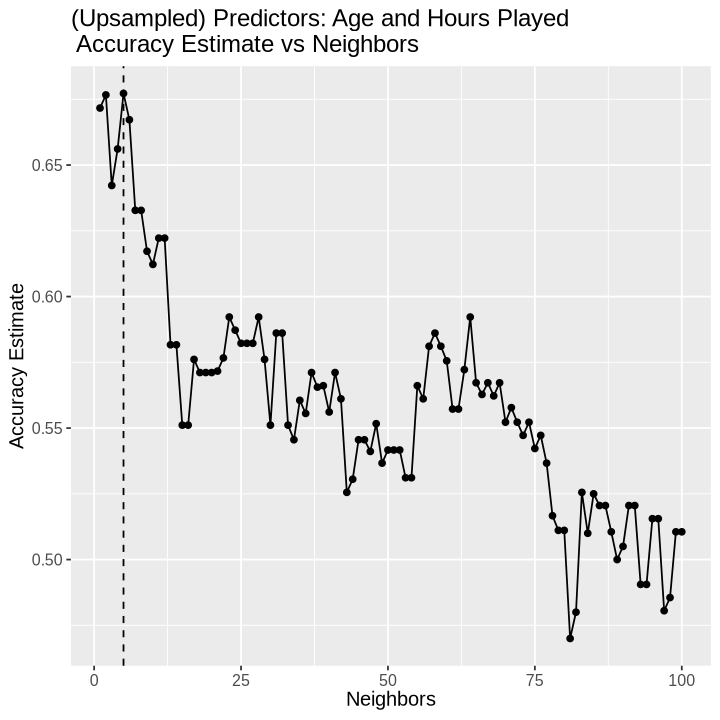

In [77]:
set.seed(1234) # Seed for possible recreation

# Filtering metrics for just accuracy
upsampled_age_played_hours_accuracies <- upsampled_knn_age_played_hours_results |>
    filter(.metric == "accuracy")

# Pulling the most accurate k-value
upsampled_best_k_age_played_hours <- upsampled_age_played_hours_accuracies |>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
upsampled_best_k_age_played_hours

# Accuracy Estimate vs Neighbors visualization.
upsampled_accuracy_vs_k_age_played_hours <- ggplot(upsampled_age_played_hours_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  geom_vline(xintercept = upsampled_best_k_age_played_hours, linetype = "dashed") +
  labs(title = "(Upsampled) Predictors: Age and Hours Played \n Accuracy Estimate vs Neighbors", x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))
upsampled_accuracy_vs_k_age_played_hours

_**(Figure 18)** :_

In [65]:
set.seed(1234) # Seed for possible recreation

# Model for KNN classification using neighbor value that yields highest accuracy (K = 5)
upsampled_best_knn_spec_age_played_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = upsampled_best_k_age_played_hours) |>
  set_engine("kknn") |>
  set_mode("classification")

# Fitting the recipe and model to the upsampled testing data
upsampled_knn_fit_age_played_hours <- workflow() |>
  add_recipe(upsampled_players_age_played_hours_recipe) |>
  add_model(upsampled_best_knn_spec_age_played_hours) |>
  fit(data = upsampled_players_testing)

# Predicting + binding predictions onto the upsampled testing data
upsampled_players_age_played_hours_test_prediction <- predict(upsampled_knn_fit_age_played_hours, upsampled_players_testing) |>
    bind_cols(upsampled_players_testing)

# Filtering for accuracy
upsampled_players_age_played_hours_test_prediction_acc <- upsampled_players_age_played_hours_test_prediction |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
upsampled_players_age_played_hours_test_prediction_acc

# Confusion Matrix for this algorithm's performance on the upsampled testing data
upsampled_players_age_played_hours_test_prediction_conf <- upsampled_players_age_played_hours_test_prediction |>
             conf_mat(truth = subscribe, estimate = .pred_class)
upsampled_players_age_played_hours_test_prediction_conf

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6511628


          Truth
Prediction FALSE TRUE
     FALSE    35   22
     TRUE      8   21

_**(Figure 19)** :_

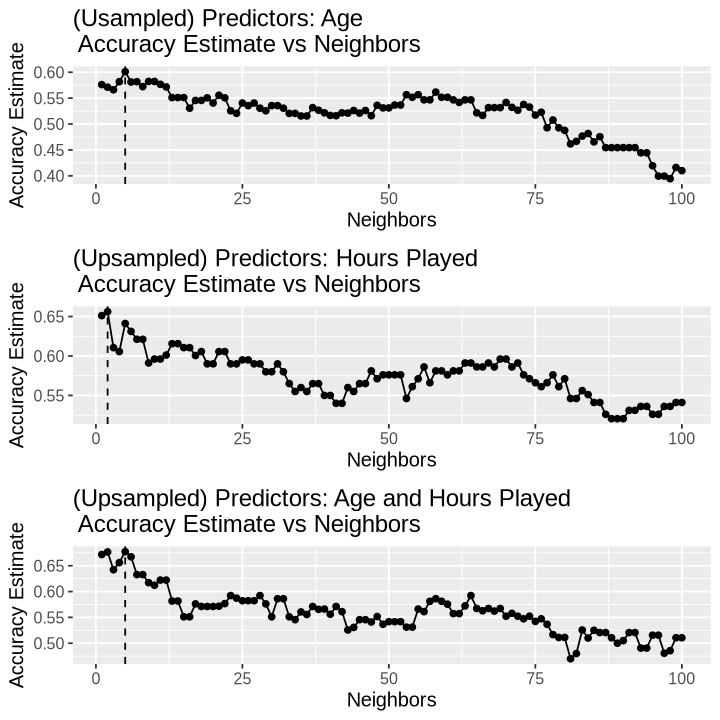

In [79]:
plot_grid(upsampled_accuracy_vs_k_age, upsampled_accuracy_vs_k_played_hours, upsampled_accuracy_vs_k_age_played_hours, ncol = 1)

_**(Figure 20)** :_

In [94]:
upsampled_age_accuracy <- upsampled_players_age_test_prediction_acc |>
    pull(.estimate)

upsampled_played_hours_accuracy <- upsampled_players_played_hours_test_prediction_acc |>
    pull(.estimate)

upsampled_age_played_hours_accuracy <- upsampled_players_age_played_hours_test_prediction_acc |>
    pull(.estimate)

upsampled_accuracies <- tibble(predictors = c("Age", "played_hours", "Age_played_hours"),
                     upsampled_k_value = c(upsampled_best_k_age, upsampled_best_k_played_hours, upsampled_best_k_age_played_hours),
                     upsampled_accuracies = c(upsampled_age_accuracy, upsampled_played_hours_accuracy, upsampled_age_played_hours_accuracy))
upsampled_accuracies

predictors,upsampled_k_value,upsampled_accuracies
<chr>,<int>,<dbl>
Age,5,0.5697674
played_hours,2,0.6279070
Age_played_hours,5,0.6511628


_**(Figure 21)** :_

## Discussion